<a href="https://colab.research.google.com/github/ahmed-ali-mj/GEE-RE-optimizer/blob/main/GEE_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial set up**

Install needed

In [3]:
!pip install pvlib # Install pvlib
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.

Imports

In [1]:
import ee
import matplotlib.pyplot as plt
import math
import calendar
import csv
from datetime import datetime,timedelta
import pvlib
import pandas as pd
import numpy as np
from google.colab import files
from ortools.linear_solver import pywraplp

**Parameters**

In [2]:
# Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-ahmedalimj')

# Example usage
# Karachi coordinates
latitude = 24.8607
longitude = 67.0011

# Wind turbine Constants
air_density = 1.225  # kg/m^3
rotor_diameter = 222  # meters
rated_power_turbine = 14000  # kW (14 MW)
rated_wind_speed = 8.7  # m/s
cut_in_wind_speed = 3.0  # m/s
cut_out_wind_speed = 32.0  # m/s

# Solar panel constants
panel_area = 2.6     # m²
efficiency_solar = 0.22    # 22% efficiency
rated_power_panel = 585 # W


solar_costs = [350, 350, 350, 350]  # USD per kW
wind_cost = 1500 # USD per kW
battery_cost = 300 # USD per kWh lithium

coordinates = [longitude,latitude ]

# **Wind calculations**

In [3]:
def get_wind_speeds(coordinates, start_date, end_date):
    """
    Retrieves historical wind speed data from ERA5 for a given location and time period.

    Args:
        coordinates: A list containing the longitude and latitude of the location [longitude, latitude].
        start_date: The start date for the wind speed data retrieval (YYYY-MM-DD).
        end_date: The end date for the wind speed data retrieval (YYYY-MM-DD).

    Returns:
        A list of wind speeds (in m/s) for the specified time period and location.
    """
    try:
        # Load ERA5 hourly data
        era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
            .filterDate(start_date, end_date) \
            .select(['u_component_of_wind_10m', 'v_component_of_wind_10m'])

        # Define point
        point = ee.Geometry.Point(coordinates)

        # Compute wind speed magnitude
        def calc_speed(image):
            u = image.select('u_component_of_wind_10m')
            v = image.select('v_component_of_wind_10m')
            speed = u.hypot(v).rename('wind_speed')
            return image.addBands(speed).select('wind_speed').copyProperties(image, ['system:time_start'])

        wind_speed_collection = era5.map(calc_speed)

        # Sample wind speed values at the point
        wind_speed_data = wind_speed_collection.getRegion(point, 1000).getInfo()

        # Extract wind speed values and timestamps
        wind_speeds = []
        for i in range(1, len(wind_speed_data)):
            timestamp = wind_speed_data[i][0]  # milliseconds since epoch
            speed = wind_speed_data[i][4]  # wind_speed value
            if speed is not None:
                dt = datetime.strptime(timestamp, "%Y%m%dT%H")
                wind_speeds.append(speed)

        return wind_speeds

    except Exception as e:
        return f"An error occurred: {e}"



#Break 1 year into 3 sections due to memory limitations
start_date = '2024-01-01'
end_date = '2024-06-01'

wind_speeds = get_wind_speeds(coordinates, start_date, end_date)


start_date = '2024-06-01'
end_date = '2024-10-01'

wind_speeds = wind_speeds + get_wind_speeds(coordinates, start_date, end_date)

start_date = '2024-10-01'
end_date = '2025-01-01'

wind_speeds = wind_speeds + get_wind_speeds(coordinates, start_date, end_date)

# Display result
if isinstance(wind_speeds, list):
    print(f"Retrieved {len(wind_speeds)} wind speed samples.")
    print(len(wind_speeds)/24)
else:
    print(wind_speeds)

Retrieved 8784 wind speed samples.
366.0


**Wind turbine power model**

In [4]:
def wind_power(wind_speed):


    # Swept area (A) of the turbine
    radius = rotor_diameter / 2
    swept_area = math.pi * radius**2  # m^2

    # If wind speed is outside the operational range, return 0 for no power generated
    if wind_speed < cut_in_wind_speed or wind_speed > cut_out_wind_speed:
        return 0

    # Calculate power output using the cubic wind speed power formula
    power = 0.5 * air_density * swept_area * (wind_speed ** 3) / 1e3  # Convert from watts to kilowatts

    # Cap the power at the rated power if wind speed is at or above rated wind speed
    if power >= rated_power_turbine:
        power = rated_power_turbine

    return power

In [5]:
year = 2024

def calculate_energy(wind_speeds):
    """
    Calculates the total energy produced based on wind speeds.

    Args:
        wind_speeds: A list of hourly wind speeds.

    Returns:
        A dictionary containing daily and monthly energy production.
    """

    # Placeholder energy calculation (replace with your actual energy calculation model)
    # This is a simplified example assuming a linear relationship between wind speed and energy
    wind_energy_per_hour = [wind_power(speed) for speed in wind_speeds]  # Example calculation, adjust as needed

    daily_energy = []
    monthly_energy = []

    # Calculate daily energy production
    for i in range(0, len(wind_energy_per_hour), 24):
        daily_energy.append(sum(wind_energy_per_hour[i:i + 24]))

    day_counter = 0
    for month in range(1, 13):
        days_in_month = calendar.monthrange(year, month)[1]  # Get number of days in the month
        monthly_energy.append(sum(daily_energy[day_counter : day_counter + days_in_month]))
        day_counter += days_in_month

    return {"daily": daily_energy, "monthly": monthly_energy, "hourly": wind_energy_per_hour}




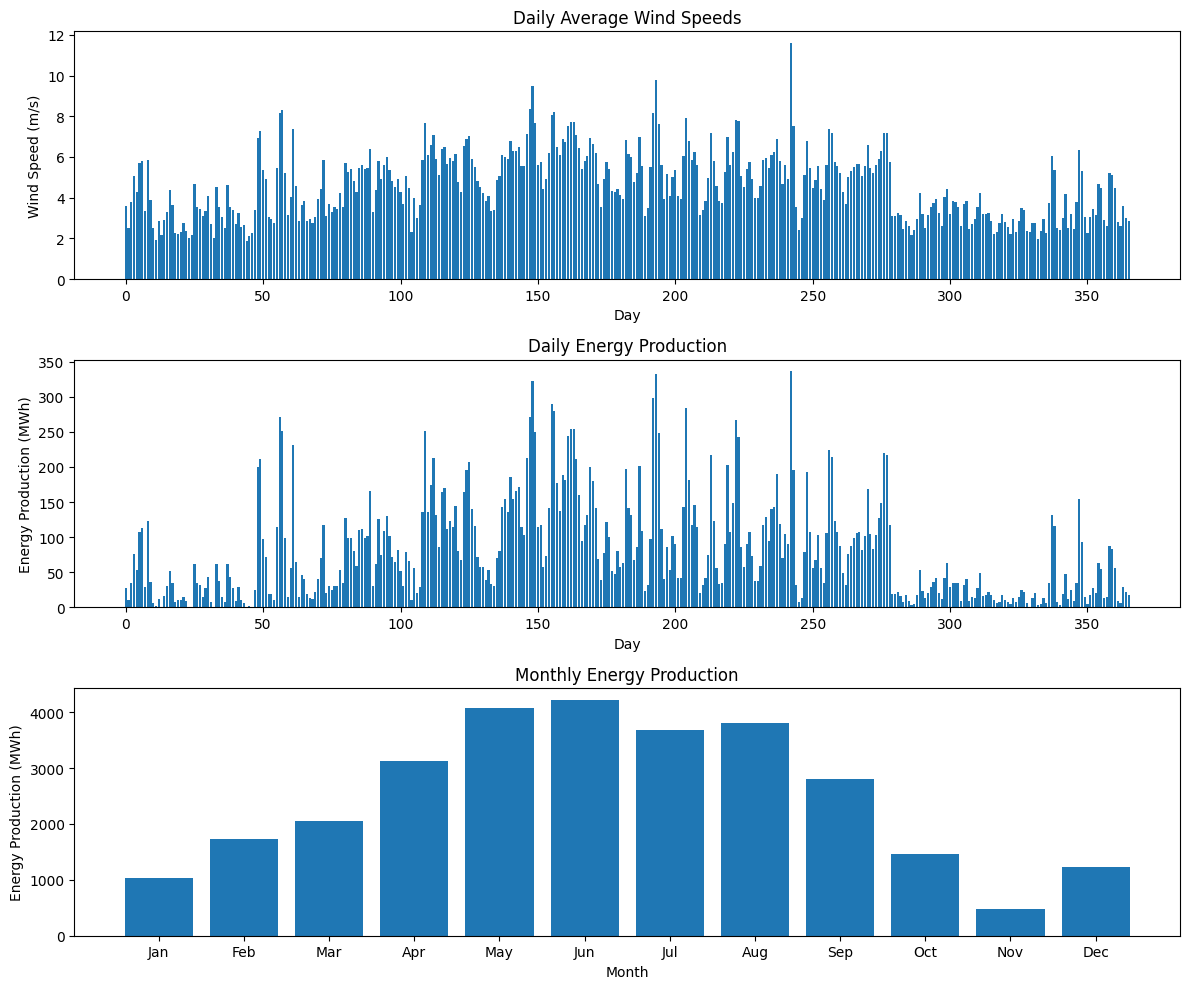

In [6]:
energy_data = calculate_energy(wind_speeds)
daily_energy = energy_data["daily"]
monthly_energy = energy_data["monthly"]
wind_hourly_energy = energy_data["hourly"]


# Daily average wind speeds (simplified example, replace with actual average calculation)
daily_avg_wind_speeds = [sum(wind_speeds[i:i+24])/24 for i in range(0, len(wind_speeds), 24)]


# Create the plot
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# Month names (adjust if needed)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot daily average wind speeds
x_axis = range(len(daily_avg_wind_speeds)) # x axis values for daily wind speeds
axs[0].bar(x_axis, daily_avg_wind_speeds)
axs[0].set_title('Daily Average Wind Speeds')
axs[0].set_xlabel('Day')
axs[0].set_ylabel('Wind Speed (m/s)')

# Plot daily energy production
x_axis = range(len(daily_energy)) # x axis values for daily energy
daily_energy = [x / 1000 for x in daily_energy]
axs[1].bar(x_axis, daily_energy)
axs[1].set_title('Daily Energy Production')
axs[1].set_xlabel('Day')
axs[1].set_ylabel('Energy Production (MWh)')

#Plot monthly energy production
x_axis = range(len(monthly_energy)) # x axis values for monthly energy
monthly_energy = [x / 1000 for x in monthly_energy]
axs[2].bar(x_axis, monthly_energy)
axs[2].set_title('Monthly Energy Production')
axs[2].set_xlabel('Month')  # Now the x-axis labels are months
axs[2].set_ylabel('Energy Production (MWh)')
axs[2].set_xticks(x_axis)  # Set x-ticks to the correct positions
# Adjust the number of month names to match the number of ticks
axs[2].set_xticklabels(month_names[:len(x_axis)])  # Set the x-axis tick labels to month names, ensuring the length matches x_axis

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [7]:
# Assuming wind_speeds, daily_energy, monthly_energy, and daily_avg_wind_speeds are already calculated

# Prepare data for CSV export
data = []
# Assuming wind_speeds correspond to hourly data points, adjust indexing if needed.
# The provided code does not include date and hour info so I will create a placeholder date range.
start_datetime = datetime(2024, 1, 1, 0, 0) # start of the time range
for i in range(len(wind_speeds)):
    current_datetime = start_datetime + timedelta(hours=i)
    date = current_datetime.strftime("%Y-%m-%d")
    hour = current_datetime.strftime("%H")
    data.append([
        date,
        hour,
        wind_speeds[i],
        wind_hourly_energy[i],
        daily_avg_wind_speeds[i // 24] if i % 24 == 0 else "", # daily average for the day
        monthly_energy[current_datetime.month -1] if i % (24*30.4) == 0 else "" # monthly average, approximate number of days in a month
    ])

# Write data to CSV
with open('wind_energy_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Date", "Hour", "Wind Speed (m/s)", "Power Produced (kW)", "Daily Average Wind Speed (m/s)", "Monthly Average Energy Production (MWh)"])
    writer.writerows(data)

**End of wind calculations**

# **Solar irradiance calculation**

In [8]:
def get_hourly_solar_irradiance(coordinates, start_date, end_date):
    """
    Retrieves hourly solar irradiance (in W/m^2) at a specific point using ERA5.

    Parameters:
        coordinates (list): [lon, lat]
        start_date (str): 'YYYY-MM-DD'
        end_date (str): 'YYYY-MM-DD'

    Returns:
        List of (timestamp, irradiance in W/m²)
    """
    point = ee.Geometry.Point(coordinates)

    # Load ERA5 hourly dataset and select variable
    # Use the correct band name for downward short-wave radiation
    era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
        .filterDate(start_date, end_date) \
        .select('surface_solar_radiation_downwards_hourly') # Corrected band name based on error message

    # Function to get irradiance at point per image
    def extract_irradiance(img):
        irradiance = img.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=point,
            scale=1000,
            maxPixels=1e13
        ).get('surface_solar_radiation_downwards_hourly') # Corrected band name

        timestamp = img.date().format('YYYY-MM-dd HH:mm')
        return ee.Feature(None, {
            'irradiance_Jm2': irradiance, # Keep original units for now
            'timestamp': timestamp
        })

    # Map and convert to FeatureCollection
    features = era5.map(extract_irradiance)

    # Export data to list
    feature_list = features.aggregate_array('irradiance_Jm2').getInfo()
    timestamp_list = features.aggregate_array('timestamp').getInfo()

    # Convert from J/m^2 to W/m² by dividing by 3600 (J/s = W)
    irradiance_wm2 = []
    for ts, val in zip(timestamp_list, feature_list):
        if val is not None:
            irradiance_wm2.append((ts, val / 3600.0)) # Corrected conversion

    return irradiance_wm2

# Get solar irradiance data for the whole year (broken into chunks)


# Display result
start_date = '2024-01-01'
end_date = '2025-01-01'

irradiance_data = get_hourly_solar_irradiance(coordinates, start_date, end_date)
irradiance_data.append((0,0)) # Extra row to match results size - Removed this line as it was adding an incorrect data point
print(f"Retrieved {len(irradiance_data)} hourly samples.")

# Example data: list of tuples (timestamp, value)

filename = 'solar_irradiance.csv'

# Write data to CSV file
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Timestamp', 'Irradiance_W_per_m2'])  # Header row
    writer.writerows(irradiance_data)

Retrieved 8785 hourly samples.


**Solar angles calculation**

In [9]:
def solar_angle_calculator(solpos,tilt,azimuth):
  theta = pvlib.irradiance.aoi(
  surface_tilt=tilt,
  surface_azimuth=azimuth,
  solar_zenith=solpos['zenith'],
  solar_azimuth=solpos['azimuth'])
  return theta

In [10]:
def solar_power_calculator(solpos,tilt,azimuth,results):
  theta = solar_angle_calculator(solpos,tilt,azimuth)
  theta_rad = np.radians(theta)

  # Calculate irradiance on the panel
  Irradiance_on_Panel = results['Solar Irradiance (W/m²)'] * np.cos(theta_rad)
  Irradiance_on_Panel = Irradiance_on_Panel.clip(lower=0)

  # Calculate power output
  PV_Power_Output = Irradiance_on_Panel * panel_area * efficiency_solar
  PV_Power_Output = PV_Power_Output/rated_power_panel #Normalize to KW/KW installed
  return PV_Power_Output



In [11]:
timezone = 'UTC'  # <-- Use UTC
location = pvlib.location.Location(latitude, longitude, tz=timezone)

# Define time range in UTC (hourly)
start_date = '2024-01-01'
end_date = '2025-01-01'
times = pd.date_range(start=start_date, end=end_date, freq='h', tz=timezone)

# Get solar position in UTC
solpos = location.get_solarposition(times)
# Combine results into a DataFrame
results = pd.DataFrame({
    'Time (UTC)': times,
    'Solar Zenith (°)': solpos['zenith'],
    'Solar Azimuth (°)': solpos['azimuth']
})

irradiance_values = [value[1] for value in irradiance_data]
results['Solar Irradiance (W/m²)'] = irradiance_values



# Define panel orientation
tilt = [0,latitude]  # Tilt angle in degrees
azimuth = [180,270] # Azimuth angle (180° = south-facing)

# Use set combinations only
case_combinations = [(0,0),(latitude,180),(latitude,270),(latitude,225)]

# Calculate angle of incidence (θ)
for case in case_combinations:
  pv_power = solar_power_calculator(solpos,case[0],case[1],results)
  heading  = 'PV Power Output (Normalized)(kW)' + str(case)
  results[heading] = pv_power

results = results.drop(results.index[-1])

**Display Solar results**

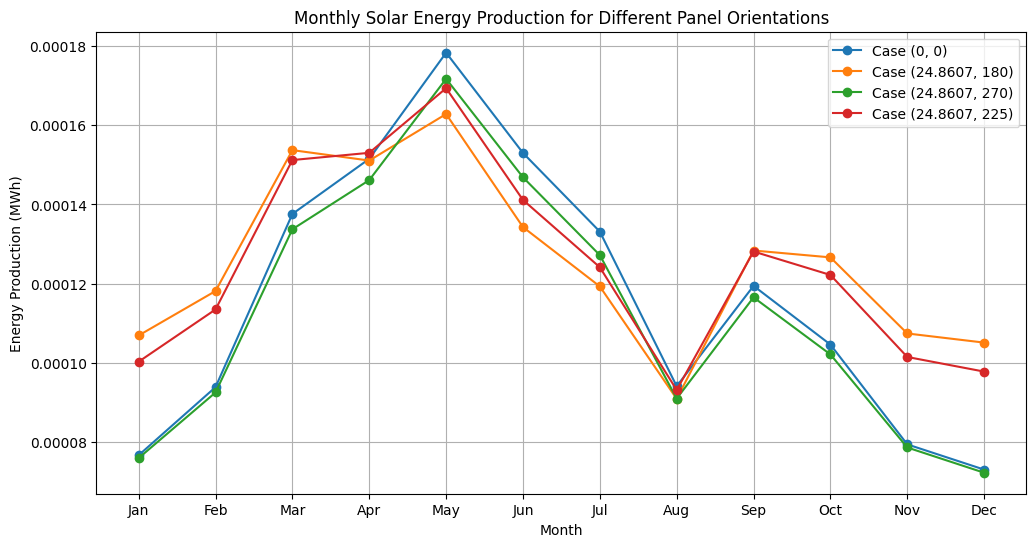

In [12]:
# prompt: use results array to display the monthly and daily sum of energy for each of the cases
# Function to calculate daily and monthly sums for each case
def calculate_daily_monthly_energy_cases(results_df):
    """
    Calculates the daily and monthly sum of energy for each PV power output case.

    Args:
        results_df: Pandas DataFrame containing hourly PV power output for each case.

    Returns:
        A dictionary where keys are the case names and values are dictionaries
        containing 'daily' and 'monthly' energy sums in MWh.
    """
    energy_sums = {}
    for col in results_df.columns:
        if 'PV Power Output (Normalized)(kW)' in col:
            case_name = col.replace('PV Power Output (Normalized)(kW)', '').strip()
            hourly_energy_Wh = results_df[col].values
            hourly_energy_kWh = hourly_energy_Wh / 1000
            hourly_energy_MWh = hourly_energy_kWh / 1000

            # Calculate daily energy
            daily_energy_MWh = []
            for i in range(0, len(hourly_energy_MWh), 24):
                daily_energy_MWh.append(np.sum(hourly_energy_MWh[i:i + 24]))

            # Calculate monthly energy
            monthly_energy_MWh = []
            # Assuming the DataFrame starts on the first day of the year
            current_day_index = 0
            for month in range(1, 13):
                # Check if the current day index is within the bounds of the daily energy list
                if current_day_index < len(daily_energy_MWh):
                    days_in_month = calendar.monthrange(year, month)[1]
                    # Ensure we don't go out of bounds when summing daily energy
                    end_day_index = min(current_day_index + days_in_month, len(daily_energy_MWh))
                    monthly_energy_MWh.append(np.sum(daily_energy_MWh[current_day_index:end_day_index]))
                    current_day_index += days_in_month
                else:
                    # If we've processed all daily data, add 0 for remaining months
                    monthly_energy_MWh.append(0)


            energy_sums[case_name] = {
                'daily': daily_energy_MWh,
                'monthly': monthly_energy_MWh
            }
    return energy_sums

# Calculate daily and monthly energy for all cases
solar_energy_cases = calculate_daily_monthly_energy_cases(results)


# You can further visualize this data if needed using matplotlib similar to the wind data plots
# Example: Plot monthly energy for each case
plt.figure(figsize=(12, 6))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for case, energy_data in solar_energy_cases.items():
    plt.plot(month_names[:len(energy_data['monthly'])], energy_data['monthly'], marker='o', label=f'Case {case}')

plt.title('Monthly Solar Energy Production for Different Panel Orientations')
plt.xlabel('Month')
plt.ylabel('Energy Production (MWh)')
plt.legend()
plt.grid(True)
plt.show()


# Combined results

In [13]:
# Normalize wind power data
wind_hourly_energy = [x / rated_power_turbine for x in wind_hourly_energy]

#Add wind energy to solar data
results['Wind speeds (m/s)'] = wind_speeds
results['Wind Turbine Power (Normalized)(kW)'] = wind_hourly_energy


# Download Energy data file
results.to_csv('yearly_energy.csv', index=False)

files.download('yearly_energy.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# print(wind_hourly_energy[0])
# print(results['Wind Turbine Power (Normalized)(kW)'].iloc[4])


# Solar indexes : 4(flat), 5(south), 6(west), 7(southwest)
# Wind index : 8
columns = list(results.columns)

# **Optimization**

Import load file

In [15]:
# Define the number of hours in 2024
num_hours_2024 = 24 * 366 # 2024 is a leap year

# Create a list of datetime objects for each hour in 2024
start_time = datetime(2024, 1, 1, 0, 0)
hours_2024 = [start_time + timedelta(hours=i) for i in range(num_hours_2024)]

# Create a list of strings in the desired format
formatted_hours = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in hours_2024]

# Create the data for the CSV
csv_data = [['Hours (UTC+0)', 'Load (kW)']] + [[hour, 10] for hour in formatted_hours]

# Define the filename
filename = '2024_hourly_load_template.csv'

# Write the data to a CSV file
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

# Download the CSV file
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
uploaded = files.upload()
load = []
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    # Read the uploaded CSV file
    df_load = pd.read_csv(fn)

    # Extract the 'Load (kW)' column
    if 'Load (kW)' in df_load.columns:
        load_data = df_load['Load (kW)'].tolist()
        load = load_data
        print("Successfully extracted 'Load (kW)' column.")
        # You can now use the 'load_data' list for further processing
        # print(load_data[:10]) # Print first 10 values to verify
    else:
        print(f"Error: 'Load (kW)' column not found in the file {fn}")


Saving 2024_hourly_load_template (1).csv to 2024_hourly_load_template (1).csv
User uploaded file "2024_hourly_load_template (1).csv" with length 210841 bytes
Successfully extracted 'Load (kW)' column.


In [22]:
# Simulated normalized data
solar_profiles =[ results[columns[4]],results[columns[5]],results[columns[6]],results[columns[7]]  ]
wind_profile = results[columns[8]]
load_profile = load  # in kW

# --- Settings ---
n_hours = 24  # Use 8760 for full year
n_solar = 4
battery_efficiency = 0.9 # 90% efficeiency
initial_soc = 0.5 # 50% Charge
max_charge_rate = 1.0    # max per hour as fraction of battery capacity
max_discharge_rate = 1.0
BIG_M = 1e6              # big number for binary logic

# Convert profiles to numpy arrays (recommended)
solar_profiles = [np.array(profile) for profile in solar_profiles]
wind_profile = np.array(wind_profile)
load_profile = np.array(load_profile)*10

# --- Solver setup ---
solver = pywraplp.Solver.CreateSolver("CBC")

# --- Decision Variables ---
solar_caps = [solver.IntVar(0, solver.infinity(), f'solar_{i}') for i in range(n_solar)]
wind_cap = solver.IntVar(0, solver.infinity(), 'wind')
battery_cap = solver.IntVar(0, solver.infinity(), 'battery')

charge = [solver.NumVar(0, solver.infinity(), f'charge_{t}') for t in range(n_hours)]
discharge = [solver.NumVar(0, solver.infinity(), f'discharge_{t}') for t in range(n_hours)]
soc = [solver.NumVar(0, solver.infinity(), f'soc_{t}') for t in range(n_hours)]
need_discharge = [solver.BoolVar(f'need_discharge_{t}') for t in range(n_hours)]

is_charging = [solver.BoolVar(f'is_charging_{t}') for t in range(n_hours)]
is_discharging = [solver.BoolVar(f'is_discharging_{t}') for t in range(n_hours)]

curtailment = [solver.NumVar(0, solver.infinity(), f"curtail_{t}") for t in range(n_hours)]

excess_gen = [solver.NumVar(0, solver.infinity(), f'excess_{t}') for t in range(n_hours)]

# --- Constraints ---
for t in range(n_hours):
    # Generation at time t
    solar_gen = sum(solar_profiles[i][t] * solar_caps[i] for i in range(n_solar))
    wind_gen = wind_profile[t] * wind_cap

    # Supply meets load
    solver.Add(solar_gen + wind_gen + discharge[t] >= load_profile[t])

    # SoC limits
    solver.Add(soc[t] <= battery_cap)

    # SoC dynamics
    if t == 0:
        solver.Add(soc[t] == initial_soc*battery_cap + battery_efficiency * charge[t] - discharge[t] / battery_efficiency)
    else:
        solver.Add(soc[t] == soc[t - 1] + battery_efficiency * charge[t] - discharge[t] / battery_efficiency)

    # Charge/discharge rate limits (as fraction of capacity)
    solver.Add(charge[t] <= max_charge_rate * battery_cap)
    solver.Add(discharge[t] <= max_discharge_rate * battery_cap)

    # Enforce binary control of charging/discharging (no simultaneous use)
    solver.Add(charge[t] <= BIG_M * is_charging[t])
    solver.Add(discharge[t] <= BIG_M * is_discharging[t])
    solver.Add(is_charging[t] + is_discharging[t] <= 1)

    # Actual excess = what's leftover AFTER meeting load with all sources
    solver.Add(excess_gen[t] >= solar_gen + wind_gen + discharge[t] - load_profile[t])
    solver.Add(excess_gen[t] >= 0)

    # Battery can only charge from this
    solver.Add(charge[t] <= excess_gen[t])

    # Step 1: Activate need_discharge only if renewables < load
    solver.Add(solar_gen + wind_gen <= load_profile[t] + BIG_M * (1 - need_discharge[t]))

    solver.Add(charge[t] <= battery_cap - soc[t])

    # Step 2: Allow discharge only if needed
    solver.Add(discharge[t] <= BIG_M * need_discharge[t])

    solver.Add(curtailment[t] == excess_gen[t] - charge[t])


# --- Objective Function: Minimize total cost ---
total_cost = (
    sum(solar_caps[i] * solar_costs[i] for i in range(n_solar)) +
    wind_cap * wind_cost +
    battery_cap * battery_cost
)
solver.Minimize(total_cost)

# --- Solve ---
status = solver.Solve()

# --- Output ---
if status == pywraplp.Solver.OPTIMAL:
    print("✅ Optimal solution found!\n")
    for i in range(n_solar):
        print(f"Solar {i+1} capacity: {solar_caps[i].solution_value():.2f} kW")
    print(f"Wind capacity: {wind_cap.solution_value():.2f} kW")
    print(f"Battery capacity: {battery_cap.solution_value():.2f} kWh")
    print(f"Total installation cost: ${solver.Objective().Value():,.2f}\n")

    print("Hour | SoC (kWh) | Charge (kW) |Discharge(kW)| Load (kW)| Solar Gen(kW) | Wind Gen(kW)| Excess gen(kW)")
    for t in range(n_hours):
        soc_val = soc[t].solution_value()
        charge_val = charge[t].solution_value()
        discharge_val = discharge[t].solution_value()
        load_val = load_profile[t]

        # Calculate solar and wind generation at this hour
        solar_gen_val = sum(solar_profiles[i][t] * solar_caps[i].solution_value() for i in range(n_solar))
        wind_gen_val = wind_profile[t] * wind_cap.solution_value()
        excess_val = excess_gen[t].solution_value()

        print(f"{t:>4} | {soc_val:>9.2f} | {charge_val:>10.2f} | {discharge_val:>12.2f} |"
              f"{load_val:>9.2f} | {solar_gen_val:>13.2f} | {wind_gen_val:>11.2f} | {excess_val:>10.2f}")

else:
    print("❌ No optimal solution found.")


✅ Optimal solution found!

Solar 1 capacity: 0.00 kW
Solar 2 capacity: 0.00 kW
Solar 3 capacity: 0.00 kW
Solar 4 capacity: 0.00 kW
Wind capacity: 40.00 kW
Battery capacity: 29.00 kWh
Total installation cost: $68,700.00

Hour | SoC (kWh) | Charge (kW) |Discharge(kW)| Load (kW)| Solar Gen(kW) | Wind Gen(kW)| Excess gen(kW)
   0 |     14.50 |       0.00 |         0.00 |   100.00 |          0.00 |      157.73 |      57.73
   1 |     21.37 |       7.63 |         0.00 |   100.00 |          0.00 |      161.71 |      61.71
   2 |     24.98 |       4.02 |         0.00 |   100.00 |          0.00 |      163.16 |      63.16
   3 |     26.89 |       2.11 |         0.00 |   100.00 |          0.00 |      164.57 |      64.57
   4 |     27.89 |       1.11 |         0.00 |   100.00 |          0.00 |      172.72 |      72.72
   5 |     27.89 |       0.00 |         0.00 |   100.00 |          0.00 |      190.94 |      90.94
   6 |     28.41 |       0.59 |         0.00 |   100.00 |          0.00 |      188.

✅ CSV saved: battery_optimization_full_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

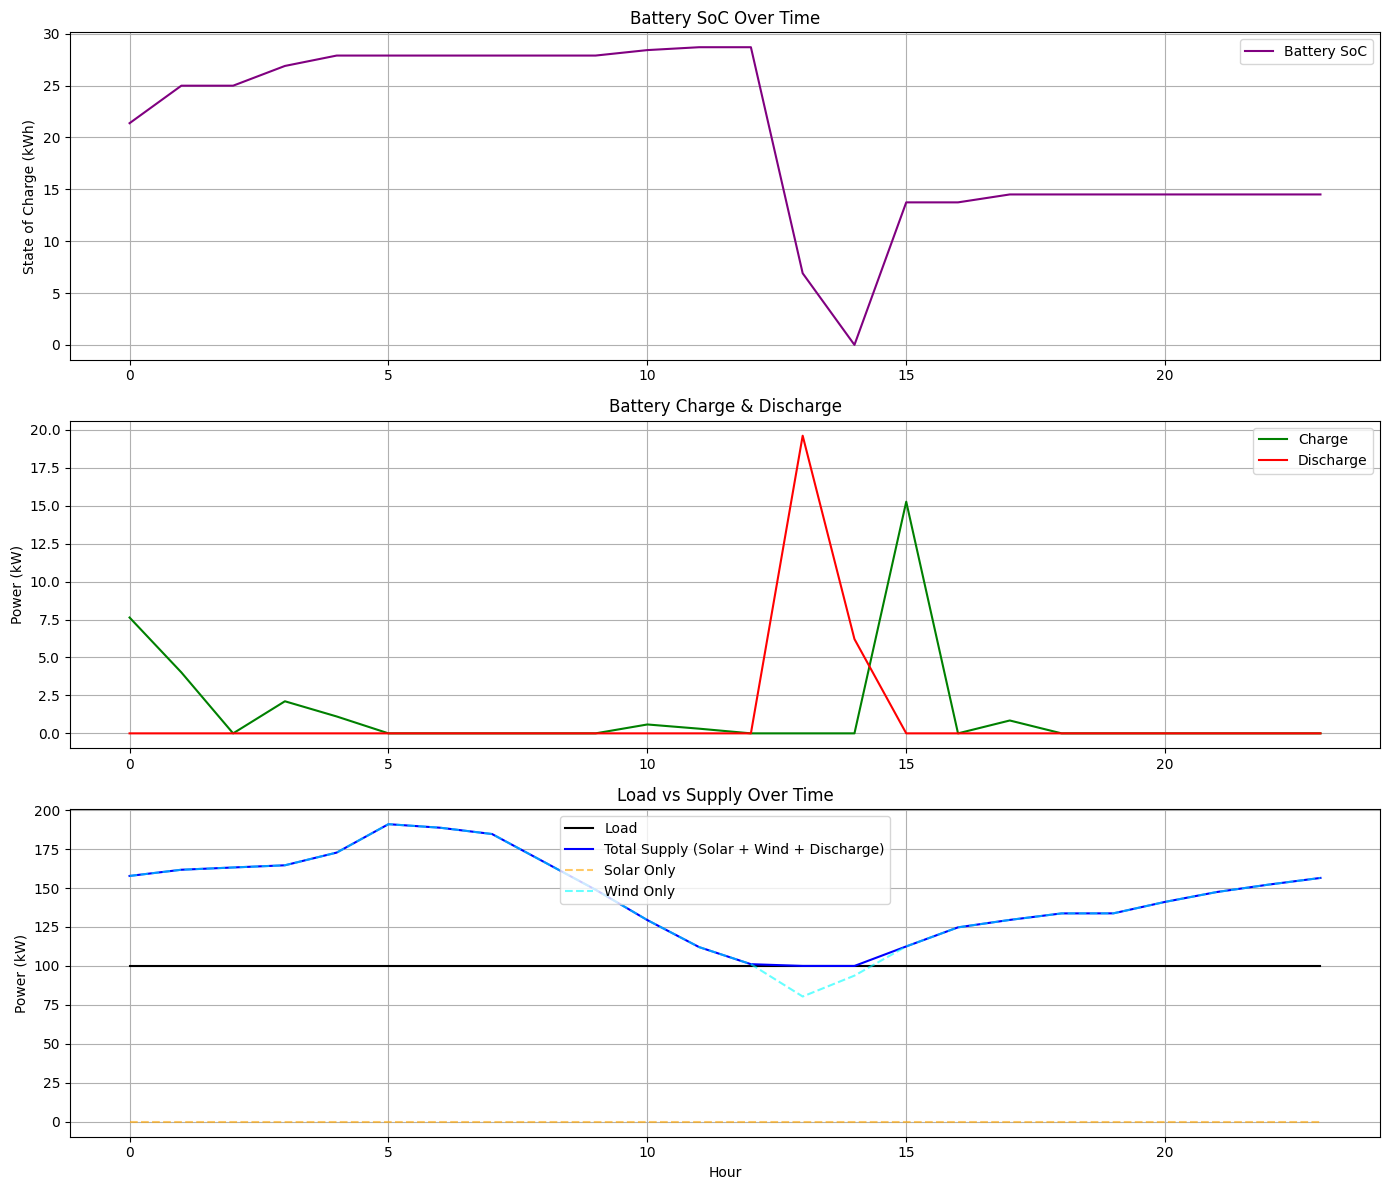

In [21]:
# --- Extract and Compute Values ---
solar_gen_vals = [
    sum(solar_profiles[i][t] * solar_caps[i].solution_value() for i in range(n_solar))
    for t in range(n_hours)
]
wind_gen_vals = [
    wind_profile[t] * wind_cap.solution_value()
    for t in range(n_hours)
]
supply_vals = [
    solar_gen_vals[t] + wind_gen_vals[t] + discharge[t].solution_value()
    for t in range(n_hours)
]
charge_vals = [charge[t].solution_value() for t in range(n_hours)]
discharge_vals = [discharge[t].solution_value() for t in range(n_hours)]
soc_vals = [soc[t].solution_value() for t in range(n_hours)]
load_vals = load_profile[:n_hours].tolist()

# Optional: Charging flags if binary variables exist
charging_flags = [is_charging[t].solution_value() if 'is_charging' in globals() else 0 for t in range(n_hours)]
discharging_flags = [is_discharging[t].solution_value() if 'is_discharging' in globals() else 0 for t in range(n_hours)]

# --- Create DataFrame ---
df = pd.DataFrame({
    'Hour': list(range(n_hours)),
    'Load (kW)': load_vals,
    'Solar Gen (kW)': solar_gen_vals,
    'Wind Gen (kW)': wind_gen_vals,
    'Total Supply (kW)': supply_vals,
    'Charge (kW)': charge_vals,
    'Discharge (kW)': discharge_vals,
    'Battery SoC (kWh)': soc_vals,
    'Is Charging': charging_flags,
    'Is Discharging': discharging_flags
})

# --- Save CSV ---
csv_filename = "battery_optimization_full_results.csv"
df.to_csv(csv_filename, index=False)
print(f"✅ CSV saved: {csv_filename}")
files.download(csv_filename)

# --- Plotting ---
plt.figure(figsize=(14, 12))

# 1. SoC over time
plt.subplot(3, 1, 1)
plt.plot(df['Hour'], df['Battery SoC (kWh)'], color='purple', label='Battery SoC')
plt.ylabel("State of Charge (kWh)")
plt.title("Battery SoC Over Time")
plt.grid(True)
plt.legend()

# 2. Charge & Discharge
plt.subplot(3, 1, 2)
plt.plot(df['Hour'], df['Charge (kW)'], label='Charge', color='green')
plt.plot(df['Hour'], df['Discharge (kW)'], label='Discharge', color='red')
plt.ylabel("Power (kW)")
plt.title("Battery Charge & Discharge")
plt.grid(True)
plt.legend()

# 3. Load vs Total Supply
plt.subplot(3, 1, 3)
plt.plot(df['Hour'], df['Load (kW)'], label='Load', color='black')
plt.plot(df['Hour'], df['Total Supply (kW)'], label='Total Supply (Solar + Wind + Discharge)', color='blue')
plt.plot(df['Hour'], df['Solar Gen (kW)'], label='Solar Only', linestyle='--', color='orange', alpha=0.6)
plt.plot(df['Hour'], df['Wind Gen (kW)'], label='Wind Only', linestyle='--', color='cyan', alpha=0.6)
plt.ylabel("Power (kW)")
plt.xlabel("Hour")
plt.title("Load vs Supply Over Time")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
